In [ ]:
!nvidia-smi

Tue Sep 14 14:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install packages
!pip install -U scikit-learn
!pip install ftfy
!pip install optuna

In [ ]:
# Imports

from google.colab import drive
import os

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
warnings.simplefilter("ignore", UserWarning)

     |████████████████████████████████| 22.3 MB 4.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# Attach Google Drive for reading and saving files
drive.mount('/content/drive')
os.chdir("drive/My Drive/PROJECT/HealthCare/FINAL_RESULTS/")

Mounted at /content/drive


In [ ]:
%%capture

In [ ]:
# Read in data and limit to training and validation sets
full_data = pd.read_excel("./full_data_fixed.xlsx")
full_data = full_data.loc[full_data['year_month'] < '2014-1-1']

In [ ]:
#@title Seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

In [ ]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        self.test_size = 36
        self.look_back = 3
        self.n_predicted_month = 3
        self.n_features = 3
        self.seed = 42
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300

args = Configuration()

In [ ]:
# Define data (pre-)processing functions
def get_city_data(city_name):
    """Returns Diarrhoea rate and climate data"""
    return full_data.loc[full_data['province'] == city_name].drop(columns=['Influenza_cases', 'Dengue_fever_cases', 'Diarrhoea_cases', 'Dengue_fever_rates', 'province', 'year_month'], 
                                                                  axis=1, 
                                                                  inplace=False)

def convert_to_stationary(city_data):
     """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [ ]:
def split_data(data):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]
    test = data[-args.test_size - args.look_back: ]
    return train, test

In [ ]:
def to_supervised(data, d_in=args.look_back, d_out=args.n_predicted_month, features_list=[]):
  """
  Frames time-series as supervised learning dataset.
  
  Args:
    d_in: lookback window
    d_out: number of predicted months
    features_list: list of all features **where last col is the disease incidence**

  Returns:
    Numpy arrays of disease incidence (y) and other predictors (X)
  """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [ ]:
def select_feature(train, specific_data):
    """Selects args.n_features top features using RFE"""
    train_X, train_y = to_supervised(train, d_in=1, d_out=1)
    train_X, train_y = np.squeeze(train_X), np.squeeze(train_y)
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=args.seed), n_features_to_select=args.n_features)
    fit = rfe.fit(train_X, train_y)
    important_features = list()
    # print("Important Feature:")
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            important_features.append(i)
            # print(specific_data.columns[i])
    return np.array(important_features)

In [ ]:
def get_data(train_np, test_np, batch_size, specific_data):
    """
    Returns important feature list and data formatted for input into Pytorch 
    models
    """
    important_features = select_feature(train_np, specific_data)

    train_X, train_y = to_supervised(train_np, features_list=important_features)
    test_X, test_y = to_supervised(test_np, features_list=important_features)
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

    return important_features, train_loader, test_tensor

In [ ]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_month)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_month)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

In [ ]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout):
      """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        if model_type.lower() == 'lstm':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'lstm_attention':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'cnn':
            model = MultivariateCNN(num_filters, dropout)
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None
    
    def evaluate_model(self, np_data=None, plot=True, scaled=True, city=None, k_steps=None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data)
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        for k_steps in range(1, args.n_predicted_month + 1):
            y_predicted = []
            y_true = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, self.important_features]
                # yhat = self.model.predict(X.unsqueeze(0)).squeeze()

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
                y_true.append(tensor_data[index + args.look_back, -1].detach().cpu().numpy())

            y_predicted = y_scaler.inverse_transform(np.array(y_predicted).reshape(-1, 1)).reshape(-1, )
            y_true = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).reshape(-1, )

            if plot==True:
                plt.plot(y_predicted, label='predicted')
                plt.plot(y_true, label='actual')
                plt.title(f"k-steps = {k_steps}")
                plt.legend()
                plt.show()

                plt.show()

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

Epoch:  0/410 - train_loss: 1.0929 - test_loss: 0.638175
Epoch: 102/410 - train_loss: 0.1865 - test_loss: 0.115734
Epoch: 204/410 - train_loss: 0.1489 - test_loss: 0.197932
Epoch: 306/410 - train_loss: 0.1846 - test_loss: 0.219745
Epoch: 408/410 - train_loss: 0.0626 - test_loss: 0.367506
Epoch: 409/410 - train_loss: 0.0697 - test_loss: 0.308714
Evaluate on test set: 


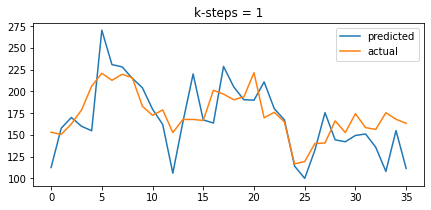

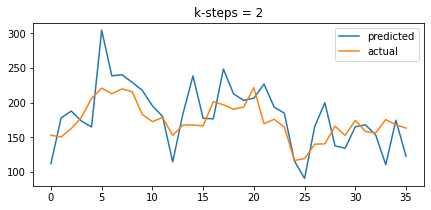

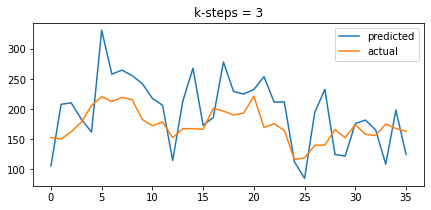

In [ ]:
cities = ['Điện Biên', 'Thái Bình', 'Lào Cai', 'Kon Tum', 'Cao Bằng']
def objective(trial): 
    city = 'Kon Tum'

    # Define search parameters
    args.epochs = trial.suggest_int('Epochs', 10, 500, step=10)
    learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
    num_filters = trial.suggest_categorical('Num. filters', [[64, 64, 64], [100, 100, 100], [128, 128, 128], [16, 32, 64], [32, 64, 128]])
    dropout = trial.suggest_uniform('Dropout rate', 0.01, 0.80)

    # Pre-process data
    specific_data = get_city_data(fix_text(city))
    specific_data = impute_missing_value(specific_data)
    specific_data = convert_to_stationary(specific_data)
    specific_data.dropna(inplace=True)
    train, test = split_data(specific_data)

    # Fit data scaler to training data
    full_scaler = MinMaxScaler().fit(train)
    y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))

    # Scale train and test data
    train = full_scaler.transform(train)
    test = full_scaler.transform(test)

    # Get data to run model
    important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, specific_data)

    # CNN model
    trainer = Trainer(type_model='cnn',
                  learning_rate=learning_rate,
                  important_features=important_features,
                  train_loader=train_loader,
                  test_tensor=test_tensor,
                  num_filters=num_filters, 
                  dropout=dropout)

    # Train model
    trainer.train(epochs=args.epochs, trial=trial)

    # Evaluate model
    _, _, rmse, mae, = trainer.evaluate_model(np_data=test, plot=False, scaled=True, city=city, y_scaler=y_scaler)

    return rmse


if __name__ == '__main__':

    # Use Tree-structured Parzen Estimator sampler to minimise RMSE
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(sampler=sampler, direction='minimize')

    # Optimise over 100 trials
    study.optimize(objective, n_trials=100, n_jobs=-1)

    # Print results
    print("Study statistics for : ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
# Plot history of RMSE values for each trial
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Plot relative importances of each hyperparameter
optuna.visualization.plot_param_importances(study)

In [ ]:
# Plot edf
optuna.visualization.plot_edf(study)

In [ ]:
# Slice plot of hyperparameters
optuna.visualization.plot_slice(study)